# Part 1: Making MCP Tools Durable with Temporal Workflows

In this workshop, we will do the following:

- Explore MCP's role in connecting AI to external systems
- Build durability and persistence to your MCP tools with Temporal
- Debug and monitor MCP tools with Temporal Web UI

## Hands-on Moments

This is a hands-on workshop!

All of the instructors slides and code samples are are executable in the workshop notebooks.
We encourage you to follow along and play with the samples!

At the end of every chapter (notebook) will be a hands-on lab.

In [2]:
%pip install --quiet temporalio fastmcp


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/azhou/Desktop/edu-ai-workshop-mcp/env/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Running this will download the Temporal CLI, which we need for this demo.

!curl -sSf https://temporal.download/cli.sh | sh

temporal: Downloading Temporal CLI latest
temporal: Temporal CLI installed at /Users/azhou/.temporalio/bin/temporal
temporal: For convenience, we recommend adding it to your PATH
temporal: If using bash, run echo export PATH="\$PATH:/Users/azhou/.temporalio/bin" >> ~/.bashrc


In [41]:
# This allows us to run the Temporal Asyncio event loop within the event loop of Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

In [55]:
# Mermaid renderer, run at the beginning to setup rendering of diagrams
import base64
from IPython.display import Image, display

def render_mermaid(graph_definition):
    """
    Renders a Mermaid diagram in Google Colab using mermaid.ink.

    Args:
        graph_definition (str): The Mermaid diagram code (e.g., "graph LR; A-->B;").
    """
    graph_bytes = graph_definition.encode("ascii")
    base64_bytes = base64.b64encode(graph_bytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

## Summary of Goals and Tools

From the last workshop, we saw:
1. Goals: Agentic systems solve problems for you on your behalf based on what you tell it what to do in human language.

### Sample goal definition:
```
goal_research_report = AgentGoal(
    id="goal_research_report",
    agent_name="Research Report Generator",
    agent_friendly_description="Generate research reports based on your topic and convert to PDF with images.",
    tools=[
        tool_registry.generate_pdf,
        tool_registry.generate_image,
    ],
    description="The user wants to generate a research report on a specific topic and convert it to a PDF document with accompanying images. To assist with that goal, help the user: "
    "1. Gather the research topic and any specific requirements or focus areas from the user "
    "2. Conduct research on the specified topic and compile findings into a comprehensive report "
    "3. Generate_image: Create relevant images to enhance the report content "
    "4. Generate_pdf: Convert the research report into a PDF format, incorporating the generated images",
)
```

2. Tools: How things actually get done. Tools can be local processes (“read this local file and show me the result”) or remote calls (“query this database”).

### Sample tool definition
```
generate_pdf_tool = ToolDefinition(
    name="generate_pdf",
    description="Generate a PDF document from research content on a specified topic, creates a formatted PDF report with the research findings, returns a success indicator and PDF file path.",
    arguments=[
        # <snip arguments definition for brevity>
    ],
)
```

You define how to solve your problems in simple, human-readable terms, and the agentic AI works with you using the available tools.

<img src="https://images.ctfassets.net/0uuz8ydxyd9p/oi0jwiOM9uG6tgLGlBrf3/8e49117667416feb4081435a7bb3ef6f/Fig2.png" />

## Limitations

However, there are some limitations. 

1. Pre-definition Constraint: The system is constrained by its pre-defined tools. 
- What if you want to use tools without pre-defining them in your application? For example: 
    1. What if a user wants to check the weather
    2. You get the response, "Sorry, I don't have weather capabilities built in yet" even though weather APIs exist and are accessible.
2. What if we wanted to make integration easy too?
    1. Each integration has its own description and format
    2. You need to maintain different versions of different integrations
    3. Adding a new tool means code changes, testing, and redeployment

What we need instead is a system where:
1. Tools can be discovered dynamically
2. Integration is standardized
3. Tools can be added without code changes

Let's explore.

## What is MCP?

- A standardized way for applications to connect to and access data and tools from various external systems and tools, rather than just being limited to the information they were trained on.
- Three main benefits:
  - a.) **Custom integrations** - Connect your applications to external services like Slack, Google Calendar, databases, and other systems
  - b.) **Portable toolset** - Build your toolset **once** using the MCP standard and use it **everywhere**. For example, create custom coding tools (boilerplate generators, prompt templates, documentation automation) that work across any MCP-compatible IDE or application (e.g VSCode, Windsurf).
  - c.) **Open-source MCP servers** - Leverage other open-source MCP servers. If you make an MCP Client, then it will allow your application to connect to other MCP servers developed by third parties.

With MCP, tools can present their capabilities to an agentic system and allow for dynamic goal solutions. 

## Two Fundamental Components in MCP:

1. **Primitives**: The things you interact with through MCP (prompts, resources like files, tools like APIs)
2. **Client-Server Architecture**: How applications communicate with downstream systems (MCP Clients, MCP Servers, transport protocols).

Let's go through the primitives first.


## How Primitives Work Together

Think of MCP like giving an AI assistant a **complete workspace** instead of just a chat window.

**Prompts** = *"Here's what I want"*
- Your instructions and requests

**Resources** = *"Here's what you need to know"*
- Background data: your codebase, database records, documentation
- Like handing someone all the project files before asking them to help

**Tools** = *"Here's what you can do"*  
- Actions the LLM can take: API calls, function execution, file operations

User prompt + injected resources + available tools = LLM decision-making

For example, a coding agent gets context not just from your prompt, but also from your codebase files (resources accessed through MCP), enabling it to understand your specific project before suggesting changes or using development tools.

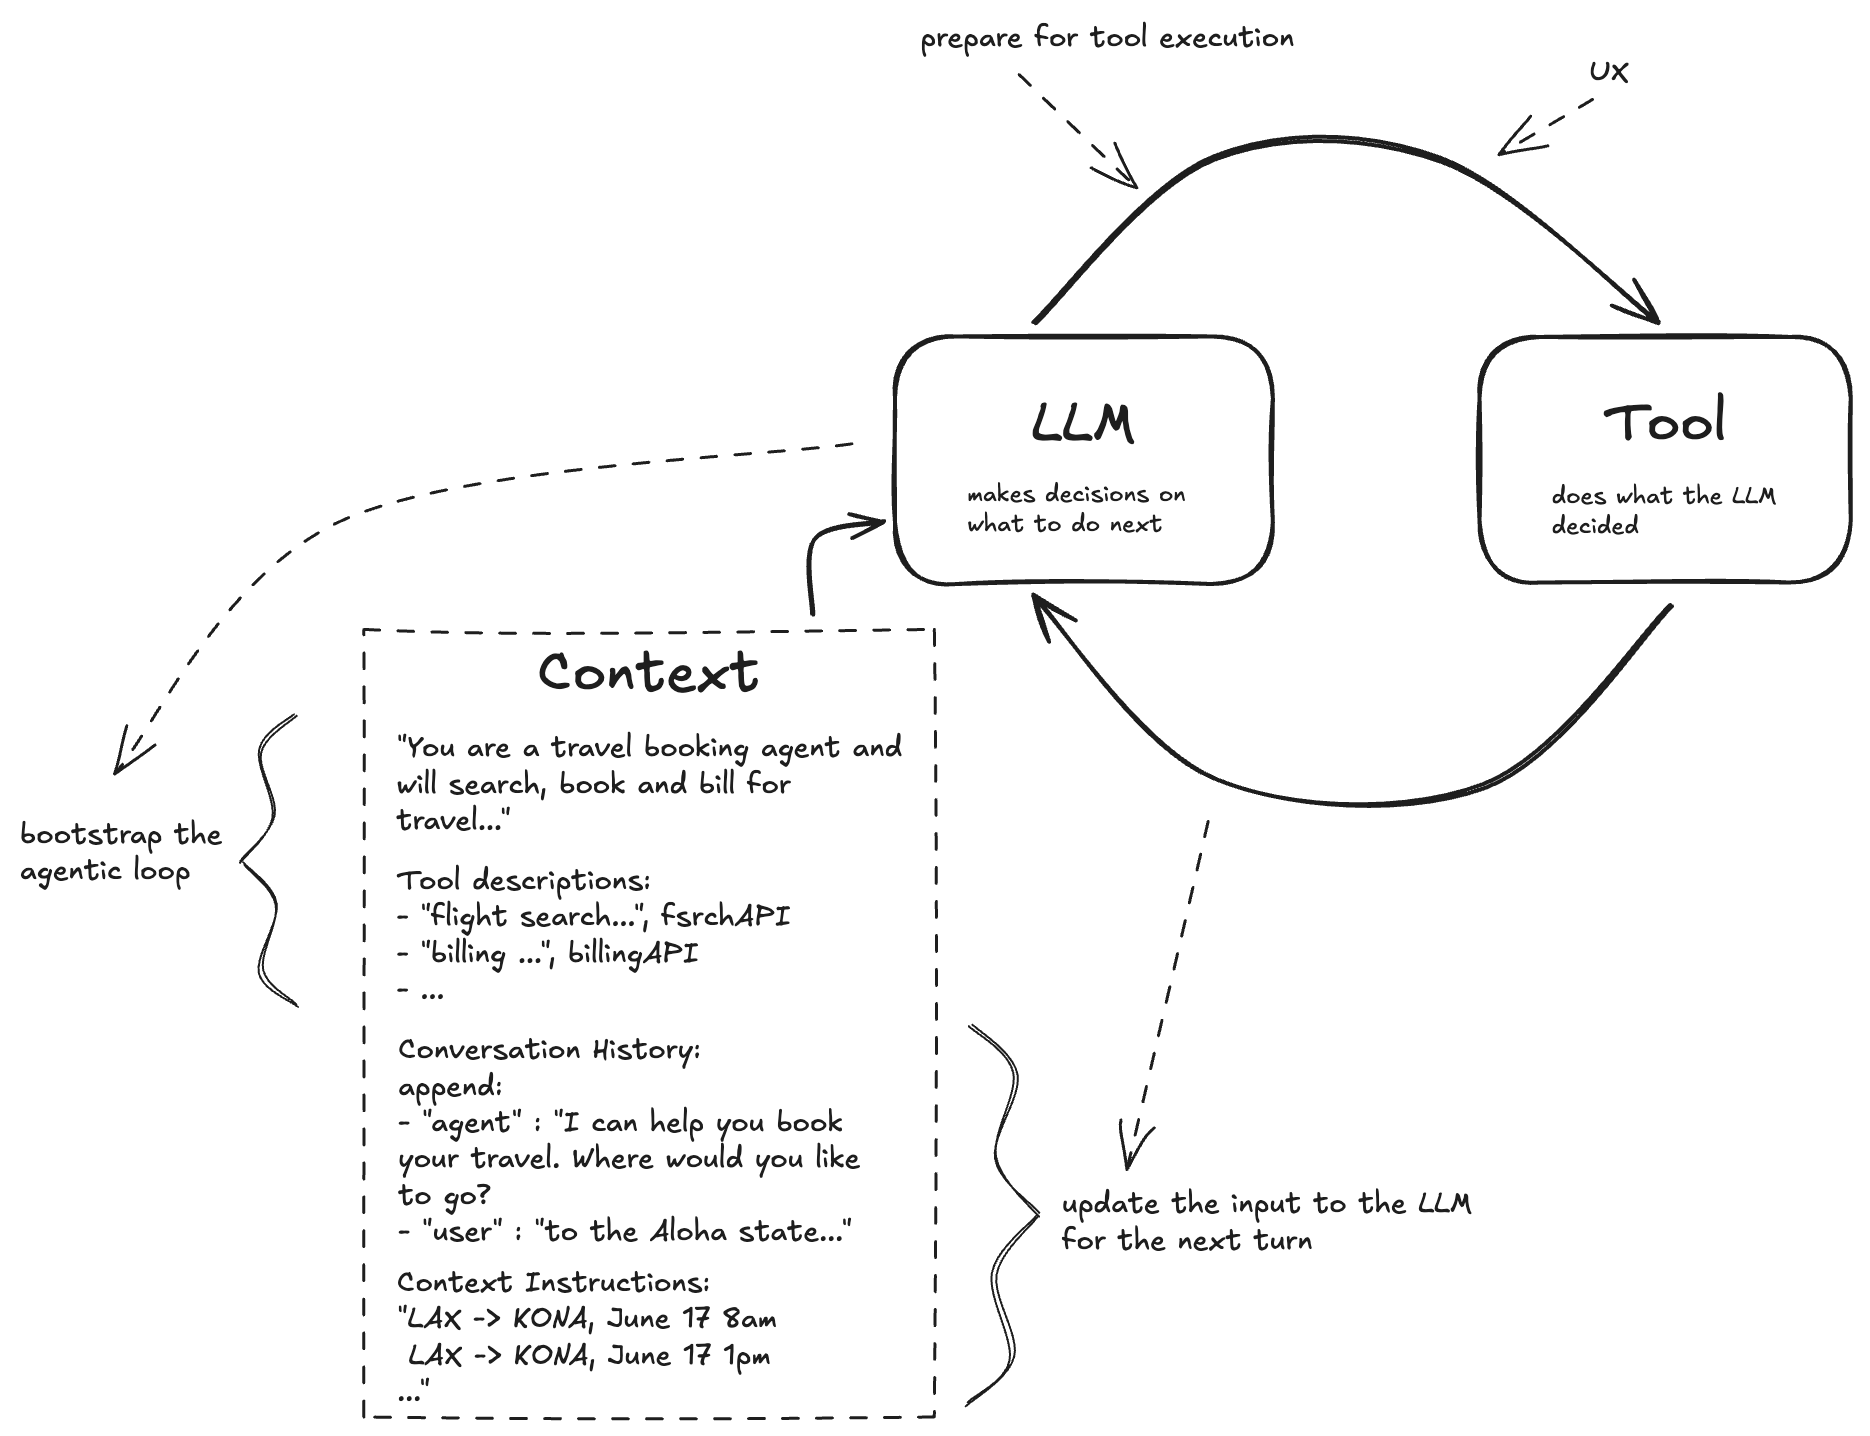

## Tools are agent-ready

The language that is describing the tool needs to be aligned with the language that the LLM is using. 

**Developer-oriented**: `GET /api/weather/forecast?location=12345&days=7`
**Agent-oriented**: "Get 7-day weather forecast for San Francisco, California."

## MCP Architecture

- MCP establishes a client-server communication model where the client and server exchange messages.
- The protocol defines how clients communicaate with the server.

## MCP Server

- A system that data owners create to make their systems accessible to AI applications
- Operates independently from the AI application, listening for requests from MCP Clients and responding accordingly.
- Provides tools, resources, and capabilities, while communicating to the Client what capabilities are available

3 Key Services:

- Prompt templates - Provides pre-built prompts for common tasks. 
    - For example, a resume rewriting template where you can swap in different resumes and target job descriptions.
- Resources - Static data access including files, databases, and external APIs. These are essentially GET requests for data lookup from various sources.
- Tools - Functions and APIs that allow MCP clients to perform actions.

Real-world Example:

A software development team builds an MCP server that connects to their:

- GitHub repositories (for code analysis and pull request management)
- Jira ticketing system (for project tracking and issue creation)
- CI/CD pipeline (for deployment status and build triggers)
- Documentation (for searching and updating technical docs)

Now any MCP-compatible application—whether it's Claude, VSCode, or a custom internal tool—can instantly access all these systems through a single, standardized interface.

## MCP Client

AI Applications that can connect to these MCP Servers to access external data and tools.

When you use Claude Desktop, you'll see various tools and integrations available to Claude in the user interface—this is because Claude Desktop has a built-in MCP Client.

MCP Clients:
- Discover server capabilities: The client asks MCP servers what tools and resources they have available.
- Handles data exchange: Receives data from servers and passes it to the AI application in the proper format.
- Manage tool execution: Coordinates when and how the AI uses different tools from connected servers.

For example, a coding agent that connects to your GitHub repositories, documentation, and development tools to understand your specific codebase and workflow.


In [58]:
durable_mcp_diagram = """
graph LR
    App[Application] 
    Client[MCP Client]
    ServerA[MCP Server A]
    ServerB[MCP Server B] 
    ServerC[MCP Server C]
    
    App <--> Client
    Client <-->|MCP Protocol| ServerA
    Client <-->|MCP Protocol| ServerB
    Client <-->|MCP Protocol| ServerC
    
    style App fill:#e1f5fe
    style Client fill:#e8f5e9
    style ServerA fill:#e3f2fd
    style ServerB fill:#e3f2fd
    style ServerC fill:#e3f2fd
"""

render_mermaid(durable_mcp_diagram)

## MCP standardizes tool integration by providing a unified protocol. 

Rather than each tool requiring its own unique communication method, applications can interface with MCP once and access multiple backend services through different MCP servers that all speak the same protocol.

<img src="https://i.postimg.cc/Pqd5LgDv/Screenshot-2025-09-26-at-12-08-40-PM.png" />

## Demo (Expand for instructor notes or to run on your own)
<!--
Prep:
1. Clone this repository: `https://github.com/temporal-community/durable-mcp/`.
2. Ahead of time, edit `claude_desktop_config.json` and add the full path to the directory containing weather.py.
3. Make sure you have Claude Desktop installed to your desktop as we will use this as our MCP Client.
4. Run `cp claude_desktop_config.json ~/Library/Application\ Support/Claude/` to connect the tools in this repository to the MCP client in Claude Desktop. Restart Claude Desktop if you have not already.

Demo: 
1. Run your temporal server: `temporal server start-dev`. 
2. Start the Temporal Worker: `uv run run_weather_worker.py` 
3. Open Claude Desktop. 
3. Ask the tool to get weather for city, for example: "What is the weather in Cary, NC?"
4. Emphasize how Claude Desktop discovers that tool dynamically. Allow it to call the `get_weather` tool.
4. Emphasize, but what about reliability?
-->

## The Limitations of MCP tools

MCP enables powerful tool integrations, but the protocol itself doesn't provide durability. When your AI agent calls an MCP tool that:
- Makes external API calls
- Processes long-running operations
- Coordinates multiple services

Now what happens if the Weather API is down? What if the network fails halfway through a Workflow? While MCP solves the standardization problem, traditional MCP tools have some limitations:

## Example of non-durable MCP tool:
```
from fastmcp import FastMCP
import httpx
import asyncio

mcp = FastMCP("fragile-weather")

@mcp.tool()
async def make_nws_request(city: str) -> str:
    async with httpx.AsyncClient() as client:
        # Network call can fail
        response = await client.get(f"https://api.weather.com/{city}")
        
    # Processing can crash
    data = response.json()
    
    # Long operation might timeout
    await asyncio.sleep(30)
    
    # No state persistence
    result = f"Weather for {city}: {data['temp']}°F"
    
    return result
```

# Adding Durablity to MCP Tools with Temporal

To add durability to our tools, we can implement MCP tools as Temporal Workflows.

| Challenge | Without Temporal | With Temporal |
|-----------|-----------------|---------------|
| **Failures** | Tool execution lost on crash | Automatic recovery and retry |
| **Long Operations** | Timeout limitations | Unlimited execution time |
| **State Management** | Complex manual handling | Built-in durable state |
| **Network Issues** | Manual retry logic needed | Automatic retry with backoff |
| **Multi-step Processes** | Difficult coordination | Natural workflow orchestration |

In [44]:
## Optional Demo (Expand for instructor notes or to run on your own).
<!--
Note that this demo is optional, because if students did the first workshop (Agentic Loop and Temporal), students should understand how Temporal maintains durability. However, feel free to run this demo if you have extra time or you want to emphasize the point.
Prep:
1. Clone this repository: `https://github.com/temporal-community/durable-mcp/`.
2. Ahead of time, edit `claude_desktop_config.json` and add the full path to the directory containing server.py.
3. Make sure you have Claude Desktop installed to your desktop as we will use this as our MCP Client.
4. Run `cp claude_desktop_config.json ~/Library/Application\ Support/Claude/` to connect the tools in this repository to the MCP client in Claude Desktop. Restart Claude Desktop if you have not already.

Demo: 
1. Run your temporal server: `temporal server start-dev`. 
2. You'll notice this repository includes a `pf.rules` file that has URLs for the news weather API. We will block those to imitate a network outage for that API.
3. Set the rules with `sudo pfctl -f pf.rules`.
4. Enable the firewall with `sudo pfctl -e`.
5. Start the Temporal Worker: `uv run run_weather_worker.py` 
6. Restart Claude Desktop. 
7. Ask the tool to get weather for city, for example: "What is the weather in Cary, NC?"
8. Go on the Web UI and point out that the `make_nws_request` Activity is retrying.
9. Disable the firewall with `sudo pfctl -d`.
10. Watch the Workflow Execution complete successfully.
-->

SyntaxError: invalid syntax (1720722329.py, line 2)

In [ ]:
## Demo #2 (Expand for instructor notes or to run on your own)
<!--
Prep:
1. Clone this repository: `https://github.com/temporal-community/durable-mcp/`.
2. Ahead of time, edit `claude_desktop_config.json` and add the full path to the directory containing server.py.
3. Make sure you have Claude Desktop installed to your desktop as we will use this as our MCP Client.
4. Run `cp claude_desktop_config.json ~/Library/Application\ Support/Claude/` to connect the tools in this repository to the MCP client in Claude Desktop. Restart Claude Desktop if you have not already.

Demo:
1. Run your temporal server: `temporal server start-dev`. 
2. Start the Temporal Worker: `uv run run_weather_worker.py` 
3. Restart Claude Code, and ask the tool to get weather for city, for example: "What is the weather in Cary, NC?"
4. Allow the tool to be used, then exit out Claude Code.
5. Go on the Web UI, and demonstrate that the Workflow is still running. 
6. Emphasize that with Temporal, the tool keeps going. The Workflow runs independently of the MCP server process.
-->

In [66]:
from IPython.display import HTML, display

display(HTML('<img src="https://iili.io/KG7nO0X.png" />'))

2025-09-30T01:22:40.786395Z  WARN temporal_client::retry: gRPC call poll_activity_task_queue retried 6 times error=Status { code: Unavailable, message: "tcp connect error", source: Some(tonic::transport::Error(Transport, ConnectError(ConnectError("tcp connect error", 127.0.0.1:7233, Os { code: 61, kind: ConnectionRefused, message: "Connection refused" })))) }
2025-09-30T01:22:40.804129Z  WARN temporal_client::retry: gRPC call poll_activity_task_queue retried 6 times error=Status { code: Unavailable, message: "tcp connect error", source: Some(tonic::transport::Error(Transport, ConnectError(ConnectError("tcp connect error", 127.0.0.1:7233, Os { code: 61, kind: ConnectionRefused, message: "Connection refused" })))) }
2025-09-30T01:22:41.027087Z  WARN temporal_client::retry: gRPC call poll_activity_task_queue retried 6 times error=Status { code: Unavailable, message: "tcp connect error", source: Some(tonic::transport::Error(Transport, ConnectError(ConnectError("tcp connect error", 127.0.0.

Let's transform a simple MCP tool into a durable one that uses a Temporal Workflow.

# Traditional MCP Tool (non-durable)

Remember without durability, if the code below fails, everything is lost - no retry, no recovery, no memory of what happened.

```
async def make_nws_request(url: str) -> dict[str, Any] | None:
    """Make a request to the NWS API with proper error handling."""
    headers = {
        "User-Agent": USER_AGENT,
        "Accept": "application/geo+json"
    }
    async with httpx.AsyncClient() as client:
        response = await client.get(url, headers=headers, timeout=5.0)
        response.raise_for_status()
        return response.json()
```

## Let's build some durable MCP tools now.

In [ ]:
## An Activity is code that is prone to failure, non-deterministic, making external calls etc.
## Step 1: Make the code an Activity. Look at the cell below for the solution.
## Step 2: Now run the code to load it into the program

from typing import Any
from temporalio import activity
import httpx

USER_AGENT = "weather-app/1.0"

async def make_nws_request(url: str) -> dict[str, Any] | None:
    """Make a request to the NWS API with proper error handling."""
    headers = {
        "User-Agent": USER_AGENT,
        "Accept": "application/geo+json"
    }
    async with httpx.AsyncClient() as client:

        response = await client.get(url, headers=headers, timeout=5.0)
        response.raise_for_status()
        return response.json()

In [54]:
## Expand for solution

from typing import Any
from temporalio import activity
import httpx

USER_AGENT = "weather-app/1.0"

@activity.defn # Implement the Activity as a function decorated with the `@activity.defn` decorator.
async def make_nws_request(url: str) -> dict[str, Any] | None:
    """Make a request to the NWS API with proper error handling."""
    headers = {
        "User-Agent": USER_AGENT,
        "Accept": "application/geo+json"
    }
    async with httpx.AsyncClient() as client:

        response = await client.get(url, headers=headers, timeout=5.0)
        response.raise_for_status()
        return response.json()


In [ ]:
## The Workflow orchestrates Activities and maintains state durably.
## Step 1: Make the Workflow call the `make_nws_request` Activity for both `points_data` and `forecast_data`. 
## Step 2: Set the Schedule-to-Close to be 40 seconds in each Activity call. Look at the cell below for the solution.
## Step 3: Now run the code to load it into the program

from temporalio import workflow
from datetime import timedelta
from temporalio.common import RetryPolicy
import asyncio

retry_policy = RetryPolicy(
    maximum_attempts=0,  # Infinite retries
    initial_interval=timedelta(seconds=2),
    maximum_interval=timedelta(minutes=1),
    backoff_coefficient=1.0,
)

# Constants
NWS_API_BASE = "https://api.weather.gov"

# sandboxed=False is a Notebook only requirement. You normally don't do this
@workflow.defn(sandboxed=False)
class GetForecast:
    @workflow.run
    async def get_forecast(self, latitude: float, longitude: float) -> str:
        """Get weather forecast for a location.

        Args:
            latitude: Latitude of the location
            longitude: Longitude of the location
        """
        # First get the forecast grid endpoint
        points_url = f"{NWS_API_BASE}/points/{latitude},{longitude}"
        points_data = await workflow.execute_activity(
            # TODO: Execute `make_nws_request` Activity,
            points_url,
            # TODO: Set Schedule-to-Close Timeout to be 40 seconds
            retry_policy=retry_policy,
        )

        if not points_data:
            return "Unable to fetch forecast data for this location."

        await workflow.sleep(10)

        # Get the forecast URL from the points response
        forecast_url = points_data["properties"]["forecast"]
        forecast_data = await workflow.execute_activity(
            # TODO: Execute `make_nws_request` Activity,
            forecast_url,
            # TODO: Set Schedule-to-Close Timeout to be 40 seconds
            retry_policy=retry_policy,
        )
        if not forecast_data:
            return "Unable to fetch detailed forecast."

        # Format the periods into a readable forecast
        periods = forecast_data["properties"]["periods"]
        forecasts = []
        for period in periods[:5]:  # Only show next 5 periods
            forecast = f"""
    {period['name']}:
    Temperature: {period['temperature']}°{period['temperatureUnit']}
    Wind: {period['windSpeed']} {period['windDirection']}
    Forecast: {period['detailedForecast']}
    """
            forecasts.append(forecast)

        return "\n---\n".join(forecasts)

In [ ]:
## Expand for solution

from temporalio import workflow
from datetime import timedelta
from temporalio.common import RetryPolicy
import asyncio

retry_policy = RetryPolicy(
    maximum_attempts=0,  # Infinite retries
    initial_interval=timedelta(seconds=2),
    maximum_interval=timedelta(minutes=1),
    backoff_coefficient=1.0,
)

# Constants
NWS_API_BASE = "https://api.weather.gov"

# sandboxed=False is a Notebook only requirement. You normally don't do this
@workflow.defn(sandboxed=False)
class GetForecast:
    @workflow.run
    async def get_forecast(self, latitude: float, longitude: float) -> str:
        """Get weather forecast for a location.

        Args:
            latitude: Latitude of the location
            longitude: Longitude of the location
        """
        # First get the forecast grid endpoint
        points_url = f"{NWS_API_BASE}/points/{latitude},{longitude}"
        points_data = await workflow.execute_activity(
            make_nws_request,
            points_url,
            schedule_to_close_timeout=timedelta(seconds=40),
            retry_policy=retry_policy,
        )

        if not points_data:
            return "Unable to fetch forecast data for this location."

        await workflow.sleep(10)

        # Get the forecast URL from the points response
        forecast_url = points_data["properties"]["forecast"]
        forecast_data = await workflow.execute_activity(
            make_nws_request,
            forecast_url,
            schedule_to_close_timeout=timedelta(seconds=40),
            retry_policy=retry_policy,
        )
        if not forecast_data:
            return "Unable to fetch detailed forecast."

        # Format the periods into a readable forecast
        periods = forecast_data["properties"]["periods"]
        forecasts = []
        for period in periods[:5]:  # Only show next 5 periods
            forecast = f"""
    {period['name']}:
    Temperature: {period['temperature']}°{period['temperatureUnit']}
    Wind: {period['windSpeed']} {period['windDirection']}
    Forecast: {period['detailedForecast']}
    """
            forecasts.append(forecast)

        return "\n---\n".join(forecasts)

In [ ]:
## Create MCP tool which calls the Workflow. This MCP tool is now durable!
## Step 1: Call the `GetForecast` Workflow. Look at the cell below for the solution.
## Step 2: Now run the code to load it into the program

# Note: MCP servers cannot be run directly in Jupyter notebooks because
# MCP servers need to run as separate processes that communicate with stdio protocol
# Therefore, we also have this code in a separate Python file that can be run
# as a standalone MCP server (mcp_servers/weather.py).

from temporalio.client import Client
from fastmcp import FastMCP

# Initialize FastMCP server
mcp = FastMCP("weather")

# Temporal client setup (do this once, then reuse)
temporal_client = None

async def get_temporal_client():
    global temporal_client
    if not temporal_client:
        temporal_client = await Client.connect("localhost:7233")
    return temporal_client

@mcp.tool
async def get_forecast(latitude: float, longitude: float) -> str:
    """Get weather forecast for a location.

    Args:
        latitude: Latitude of the location
        longitude: Longitude of the location
    """
    # The business logic has been moved into the temporal workflow, the mcp tool kicks off the workflow
    client = await get_temporal_client()
    handle = await client.start_workflow(
        workflow= # TODO: Call the `GetForecast` Workflow
        args=[latitude, longitude],
        id=f"forecast-{latitude}-{longitude}",
        task_queue="weather-task-queue",
    )
    return await handle.result()

    if __name__ == "__main__":
        mcp.run(transport='stdio')

In [ ]:
## Expand for the solution

# Note: MCP servers cannot be run directly in Jupyter notebooks because
# MCP servers need to run as separate processes that communicate with stdio protocol
# Therefore, we also have this code in a separate Python file that can be run
# as a standalone MCP server (mcp_servers/weather.py).

from temporalio.client import Client
from fastmcp import FastMCP

# Initialize FastMCP server
mcp = FastMCP("weather")

# Temporal client setup (do this once, then reuse)
temporal_client = None

async def get_temporal_client():
    global temporal_client
    if not temporal_client:
        temporal_client = await Client.connect("localhost:7233")
    return temporal_client

@mcp.tool
async def get_forecast(latitude: float, longitude: float) -> str:
    """Get weather forecast for a location.

    Args:
        latitude: Latitude of the location
        longitude: Longitude of the location
    """
    # The business logic has been moved into the temporal workflow, the mcp tool kicks off the workflow
    client = await get_temporal_client()
    handle = await client.start_workflow(
        workflow="GetForecast",
        args=[latitude, longitude],
        id=f"forecast-{latitude}-{longitude}",
        task_queue="weather-task-queue",
    )
    return await handle.result()

    if __name__ == "__main__":
        mcp.run(transport='stdio')

In [ ]:
# Run your Worker

import asyncio
from temporalio.client import Client
from temporalio.worker import Worker

async def run_worker():
    # Connect to Temporal server (change address if using Temporal Cloud)
    client = await Client.connect("localhost:7233")

    worker = Worker(
        client,
        task_queue="weather-task-queue",
        workflows=[GetForecast],
        activities=[make_nws_request],
    )
    print("Worker started. Listening for workflows...")
    await worker.run()


In [ ]:
# Due to the limitation of Jupyter Notebooks and Google Collab, this is how
# you must start the worker in a Notebook environment
worker = asyncio.create_task(run_worker())

# If you are running this code in a typical Python environment, you can start
# the Worker by just calling `asyncio.run`
# if __name__ == "__main__":
#    asyncio.run(run_worker())

## Configure Claude Desktop 
### Take 7 minutes to do the following steps.

1. The `claude_desktop_config.json` has been updated to include the weather server. Change line 7 to be the full path to the directory containing the cloned repository. For example: "/Users/azhou/Desktop/edu-ai-workshop-mcp/".
2. Run the Temporal Server: `temporal server start-dev`.
3. Make sure that you have Claude Desktop downloaded.
4. Copy this configuration to your Claude Desktop config file: `cp claude_desktop_config.json ~/Library/Application\ Support/Claude/`.
5. Restart Claude Desktop.
6. Look for the plugin icon in the chat interface - it should show your weather server is connected.
7. In Claude Desktop, try asking: "What's the weather forecast for San Francisco?"
8. Allow it to make a call to the `get_forecast` tool.
9. Open `http://localhost:8233` to see your Workflows executing in real-time!

In [ ]:
# Kill any worker to prepare for the exercise.
x = worker.cancel()

## Summary: Why Temporal and MCP?

- **You need durable tools**: Tools will be reaching out to databases, APIs, and other external systems. Again, you might get network outages, rate-limitted, the service might go down.
- **You need to be able to handle long-running processes**: You can implement a MCP tool as a Worflow, so that the tool can handle multi-step long duration processes.
- **You need persistence**: Tools can continue progressing even if the MCP Client or server crashes. The Workflow state will be stored on the Temporal server so the process continues seamlessly.
- **You need flexibility**: Tools can be built in any language Temporal supports, so a developer can build agentic capabilities in Go, Java, .NET etc.

## Exercise 1 - Making Tools Durable

* In this exercise, you will:
  * Build durability and persistence to your MCP tools with Temporal Workflows
  * Test the integration between Claude Desktop, MCP servers, and Temporal workflows
* Go to the **exercises** Directory in the Google Drive and open the `01_Making_MCP_Tools_Durable` folder. Then, open the **practice** directory.
* Open the `README.md` and follow the instructions
* If you get stuck, raise your hand and someone will come by and help. You can also check the `Solution` directory for the answers
* **You have 15 mins**